In [35]:

import numpy as np 
import pandas as pd 
import os
import cv2

## Labels

In [36]:
labels = os.listdir(r"archive\train")

In [37]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

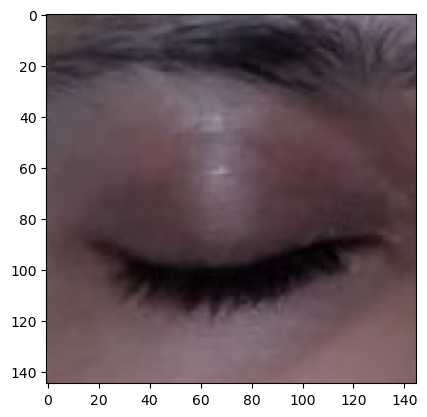

In [38]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"archive\train\Closed\_0.jpg"))

## Image array

In [39]:
a = plt.imread(r"archive\train\yawn\10.jpg")

## Image shape

In [40]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array) 


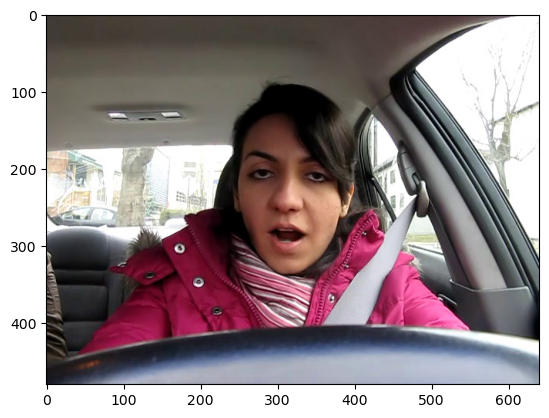

In [41]:
plt.imshow(plt.imread(r"archive\train\yawn\10.jpg"))

## Take only face(For yawn and not_yawn)

In [42]:
def face_for_yawn():
    
    direc="archive/train/"
    face_cas_path = "haarcascade_frontalface_default.xml"

    
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [43]:
def get_data(dir_path=r"archive\train", face_cas=r"archive(1)\haarcascade_frontalface_default.xml", eye_cas=r"archive(1)\haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [44]:
data_train = get_data()

2
3


## Extend data and Convert array

In [45]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [46]:
new_data = append_data()

0
1
2
3


C:\Users\HP\AppData\Local\Temp\ipykernel_7436\2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


## Separate label and features

In [47]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [48]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [49]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [50]:
y = np.array(y)

## Train Test split

In [51]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [52]:
len(X_test)

578

## Import some dependencies

In [53]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

## Data Augmentation

In [54]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [55]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [57]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 [==============================] - 185s 4s/step - loss: 0.2124 - accuracy: 0.9117 - val_loss: 0.2204 - val_accuracy: 0.9187
Epoch 2/10
43/43 [==============================] - 189s 4s/step - loss: 0.2040 - accuracy: 0.9213 - val_loss: 0.2030 - val_accuracy: 0.9360
Epoch 3/10
43/43 [==============================] - 217s 5s/step - loss: 0.1802 - accuracy: 0.9220 - val_loss: 0.1732 - val_accuracy: 0.9360
Epoch 4/10
43/43 [==============================] - 208s 5s/step - loss: 0.1975 - accuracy: 0.9235 - val_loss: 0.2036 - val_accuracy: 0.9221
Epoch 5/10
43/43 [==============================] - 202s 5s/step - loss: 0.1747 - accuracy: 0.9272 - val_loss: 0.1873 - val_accuracy: 0.9273
Epoch 6/10
43/43 [==============================] - 179s 4s/step - loss: 0.1676 - accuracy: 0.9280 - val_loss: 0.1513 - val_accuracy: 0.9464
Epoch 7/10
43/43 [==============================] - 177s 4s/step - loss: 0.1696 - accuracy: 0.9339 - val_loss: 0.1455 - val_accuracy: 0.9377
Epoch 8/10
43

## History

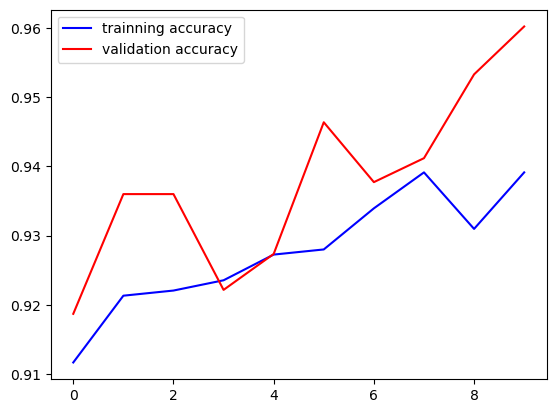

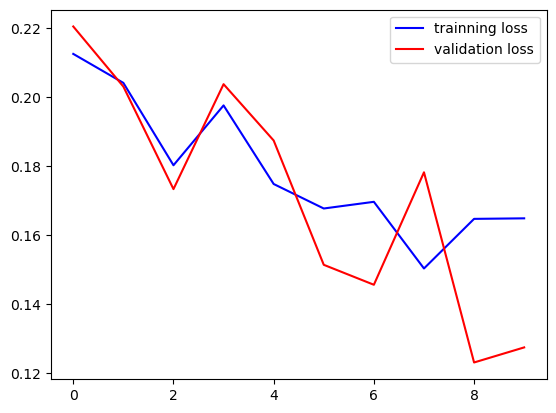

In [58]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [84]:
model.save("drowiness_new7.h5")

# Prediction

In [85]:
prediction = np.argmax(model.predict(X_test), axis=-1)

19/19 [==============================] - 19s 977ms/step


In [86]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 2, 0, 3, 3, 3,
       2, 1, 3, 2, 2, 2, 2, 2, 3, 2, 3, 2, 1, 3, 3, 2, 1, 3, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 3, 2, 1, 3, 3, 2, 2, 2, 0, 3, 3, 1, 3, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 1, 3, 1, 3, 2, 0, 3, 2, 2, 2, 2, 1,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 3, 1, 2, 3,
       1, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 2, 0, 1, 2, 3, 3, 2, 0, 3, 2,
       0, 3, 1, 2, 3, 3, 2, 1, 2, 2, 2, 1, 3, 3, 2, 3, 2, 0, 2, 3, 3, 3,
       3, 1, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 3,
       2, 2, 0, 2, 3, 0, 2, 1, 3, 2, 3, 1, 2, 0, 1, 3, 2, 2, 2, 2, 2, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 1, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 2, 2, 3, 3, 3, 3, 0, 1, 2, 1, 0, 3, 3, 1, 3, 3, 1, 3, 3, 0, 1,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 1, 3, 3, 2, 2,
       3, 2, 2, 0, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 1, 2, 2, 2, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

# classification report

In [87]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [88]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.92      0.75      0.82        63
     no_yawn       0.85      0.92      0.88        74
      Closed       0.92      0.96      0.94       215
        Open       0.95      0.94      0.94       226

    accuracy                           0.92       578
   macro avg       0.91      0.89      0.90       578
weighted avg       0.92      0.92      0.92       578



# Detecting eyes

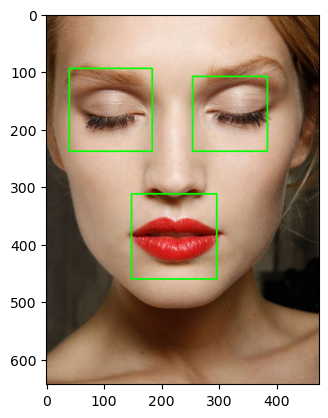

In [7]:
import matplotlib.pyplot as plt
import cv2
img = cv2.imread("close9.jpg")


FaceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

eyes = eye_cascade.detectMultiScale(gray, 1.1, 4)

for (x,y,w,h) in eyes:
     cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255,0), 2)
        
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# predicting function  (2 for closed and 3 for open)

In [37]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


def prepare(filepath):
    img = cv2.imread(filepath)
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, 1.4, 1)
    IMG_SIZE = 145
    
    for x,y,w,h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
#         if len(eyes) == 0:
#             print("eyes not detected")
        
#         else:
        for(ex,ey,ew,eh) in eyes:
            eyes_roi = roi_color[ey: ey+eh, ex:ex + ew]
             
    
    img_array = cv2.resize(eyes_roi, (IMG_SIZE, IMG_SIZE))  
    img_array = img_array / 255
    image = img_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  

    plt.imshow(img_array)
    img_array.shape
    return image



model = tf.keras.models.load_model("drowiness_model.h5")

In [38]:
image.shape

(1, 145, 145, 3)

1/1 [==============================] - 0s 217ms/step


2

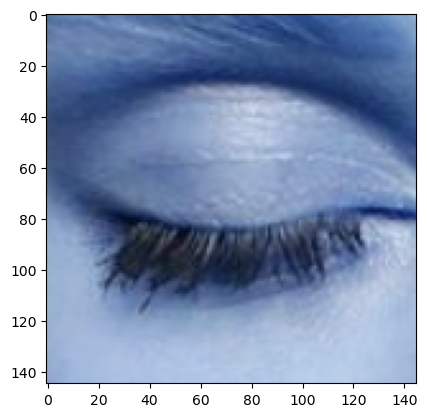

In [39]:
prediction = model.predict([prepare("close9.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 86ms/step


3

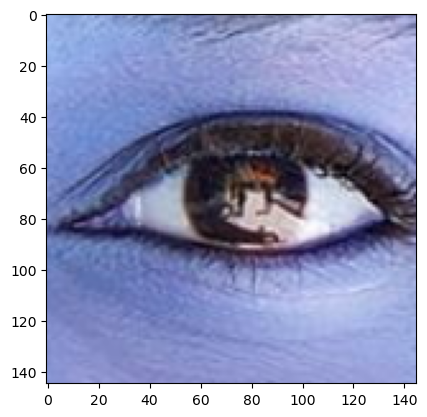

In [40]:
prediction = model.predict([prepare("face.jpg")])
np.argmax(prediction)

# Prediction function for mouth (0 for yawn and 1 for no yawn)

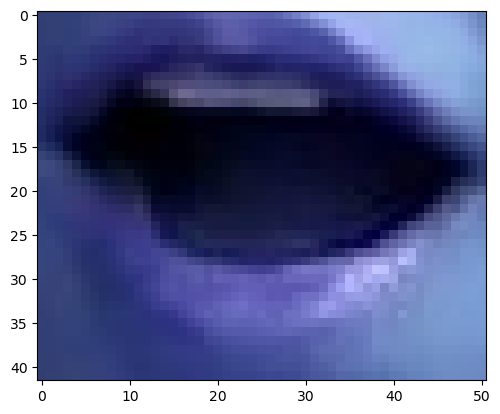

In [22]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("archive/train/yawn/12.jpg")

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Load the face detection cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect the face in the image
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# Load the facial landmark detector
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Loop over all the detected faces
for (x,y,w,h) in faces:
    # Get the facial landmarks for the face region
    landmarks = predictor(gray, dlib.rectangle(x,y,x+w,y+h))
    
    # Get the mouth region from the facial landmarks
    mouth_points = landmarks.parts()[48:68]
    
    # Convert the mouth landmarks to a numpy array
    mouth_points_array = []
    for point in mouth_points:
        mouth_points_array.append((point.x, point.y))
    mouth_points_array = np.array(mouth_points_array, dtype=np.int32)
    
    # Draw a polygon around the mouth region
#     cv2.polylines(img, [mouth_points_array], True, (0,0,255), 2)
    
    # Get the bounding rectangle around the mouth region
    x1, y1 = np.min(mouth_points_array, axis=0)
    x2, y2 = np.max(mouth_points_array, axis=0)
    
    # Crop the mouth region from the image
    mouth_img = img[y1:y2, x1:x2]
    
    # Display the cropped mouth image
    plt.imshow(mouth_img)
#     cv2.imshow("Mouth", mouth_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

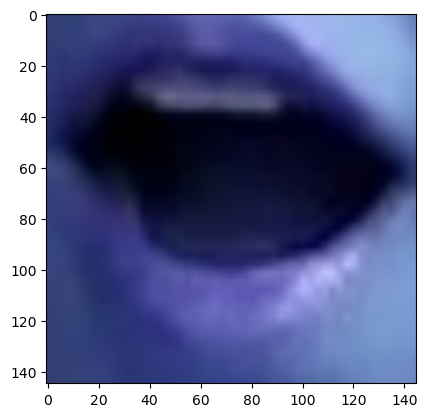

In [23]:
import tensorflow as tf 

model = tf.keras.models.load_model("drowiness_model.h5")
IMG_SIZE = 145

mouth_img = cv2.resize(mouth_img, (IMG_SIZE, IMG_SIZE))  
mouth_img = mouth_img / 255
image = mouth_img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)  

plt.imshow(mouth_img)

In [24]:
prediction = model.predict(image)
np.argmax(prediction)

1/1 [==============================] - 0s 293ms/step


2

# Loading model

In [1]:
import cv2     #this
import numpy as np

from keras.models import load_model
from keras.utils.image_utils import img_to_array
from playsound import playsound
from threading import Thread


def start_alarm(sound):
    """Play the alarm sound"""
    playsound('alarm.mp3')


classes = ['Closed', 'Open']
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
left_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +"haarcascade_lefteye_2splits.xml")
right_eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_righteye_2splits.xml")
cap = cv2.VideoCapture(0)
model = load_model("drowiness_model.h5") #drowiness_model.h5
count = 0
alarm_on = False
alarm_sound = "alarm.mp3"
status1 = ''
status2 = ''

while True:
    _, frame = cap.read()
    height = frame.shape[0]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 255), 1)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        left_eye = left_eye_cascade.detectMultiScale(roi_gray)
        right_eye = right_eye_cascade.detectMultiScale(roi_gray)
        for (x1, y1, w1, h1) in left_eye:
            cv2.rectangle(roi_color, (x1, y1), (x1 + w1, y1 + h1), (255, 255, 255), 1)
            eye1 = roi_color[y1:y1+h1, x1:x1+w1]
            eye1 = cv2.resize(eye1, (145, 145))
            eye1 = eye1.astype('float') / 255.0
            eye1 = img_to_array(eye1)
            eye1 = np.expand_dims(eye1, axis=0)
            pred1 = model.predict(eye1)
            status1=np.argmax(pred1)
            #print(status1)
            #status1 = classes[pred1.argmax(axis=-1)[0]]
            break

        for (x2, y2, w2, h2) in right_eye:
            cv2.rectangle(roi_color, (x2, y2), (x2 + w2, y2 + h2), (255, 255, 255), 1)
            eye2 = roi_color[y2:y2 + h2, x2:x2 + w2]
            eye2 = cv2.resize(eye2, (145, 145))
            eye2 = eye2.astype('float') / 255.0
            eye2 = img_to_array(eye2)
            eye2 = np.expand_dims(eye2, axis=0)
            pred2 = model.predict(eye2)
            status2=np.argmax(pred2)
            #print(status2)
            #status2 = classes[pred2.argmax(axis=-1)[0]]
            break

        # If the eyes are closed, start counting
        if status1 == 2 and status2 == 2:
        #if pred1 == 2 and pred2 == 2:
            count += 1
            cv2.putText(frame, "Eyes Closed, Frame count: " + str(count), (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
            # if eyes are closed for 10 consecutive frames, start the alarm
            if count >= 10:
                cv2.putText(frame, "Drowsiness Alert!!!", (100, height-20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
                if not alarm_on:
                    alarm_on = True
                    # play the alarm sound in a new thread
                    t = Thread(target=start_alarm, args=(alarm_sound,))
                    t.daemon = True
                    t.start()
                    continue
        else:
            cv2.putText(frame, "Eyes Open", (10, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
            count = 0
            alarm_on = False

    cv2.imshow("Drowsiness Detector", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [2]:
# importing necessary library   #or thiss
import cv2 as cv
import numpy as np

from keras.models import load_model
from keras.utils.image_utils import img_to_array
from playsound import playsound
from threading import Thread

#loading cascading class
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_eye.xml")
left_eye_cascade = cv.CascadeClassifier(cv.data.haarcascades +"haarcascade_lefteye_2splits.xml")
right_eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_righteye_2splits.xml")

status1 = ''
status2 = ''

model = load_model("drowiness_new7.h5")
count = 0
alarm_on = False
alarm_sound = "alarm.mp3"

#capturing video through webcam
video_capture = cv.VideoCapture(0)

# reading all frames through webcam
while True:
    ret, frame = video_capture.read()
    #video feed should be flipped so that it appears mirror like
    frame = cv.flip(frame,1)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x,y,w,h) in faces:
        cv.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
        region_gray = gray[y:y+h, x:x+w]
        region_color = frame[y:y+h, x:x+w]
        left_eye = left_eye_cascade.detectMultiScale(region_gray)
        right_eye = right_eye_cascade.detectMultiScale(region_gray)

        eyes = eye_cascade.detectMultiScale(region_gray)
        
        
        for (x1, y1, w1, h1) in left_eye:
            cv.rectangle(region_color, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1)
            eye1 = region_color[y1:y1+h1, x1:x1+w1]
            eye1 = cv.resize(eye1, (145, 145))
            eye1 = eye1.astype('float') / 255.0
            eye1 = img_to_array(eye1)
            eye1 = np.expand_dims(eye1, axis=0)
            pred1 = model.predict(eye1)
            status1=np.argmax(pred1)
            #print(status1)
            #status1 = classes[pred1.argmax(axis=-1)[0]]
            break
            
            
            
        for (x2, y2, w2, h2) in right_eye:
            cv.rectangle(region_color, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 0), 1)
            eye2 = region_color[y2:y2 + h2, x2:x2 + w2]
            eye2 = cv.resize(eye2, (145, 145))
            eye2 = eye2.astype('float') / 255.0
            eye2 = img_to_array(eye2)
            eye2 = np.expand_dims(eye2, axis=0)
            pred2 = model.predict(eye2)
            status2=np.argmax(pred2)
            #print(status2)
            #status2 = classes[pred2.argmax(axis=-1)[0]]
            break 
            
            
        # If the eyes are closed, start counting
        if status1 == 2 and status2 == 2:
        #if pred1 == 2 and pred2 == 2:
            count += 1
#             cv.putText(frame, "Eyes Closed, Frame count: " + str(count), (10, 30), cv.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
            # if eyes are closed for 10 consecutive frames, start the alarm
            if count >= 10:
                cv.putText(frame, "Drowsiness Alert!!!", (100, height-20), cv.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
                if not alarm_on:
                    alarm_on = True
                    # play the alarm sound in a new thread
                    t = Thread(target=start_alarm, args=(alarm_sound,))
                    t.daemon = True
                    t.start()
                    continue
        else:
#             cv.putText(frame, "Eyes Open", (10, 30), cv.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
            count = 0
            alarm_on = False


#         for (ex,ey,ew,eh) in eyes:
#             cv.rectangle(region_color, (ex,ey), (ex+ew,ey+eh), (0,255,0),2)





    cv.imshow('Video', frame)
    if(cv.waitKey(1) & 0xFF == ord('q')):
        break

#release video capture
video_capture.release()
cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [1]:
# importing necessary library
import cv2 as cv
import numpy as np
from keras.models import load_model
from keras.utils.image_utils import img_to_array
from playsound import playsound
from threading import Thread

#loading cascading class
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_eye.xml")

#loading model 
model = load_model("drowiness_new7.h5")

#capturing video through webcam
video_capture = cv.VideoCapture(0)

count = 0
status = ''
alarm_on = False
alarm_sound = "alarm.mp3"


def start_alarm(sound):
    """Play the alarm sound"""
    playsound('alarm.mp3')


# reading all frames through webcam
while True:
    ret, frame = video_capture.read()
    height = frame.shape[0]
    #video feed should be flipped so that it appears mirror like
    frame = cv.flip(frame,1)
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    for (x,y,w,h) in faces:
        cv.rectangle(frame, (x,y), (x+w,y+h), (255,255,255), 2)
        region_gray = gray[y:y+h, x:x+w]
        region_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(region_gray)

        for (x1, y1, w1, h1) in eyes:
            cv.rectangle(region_color, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 1)
            eye = region_color[y1:y1+h1, x1:x1+w1]
            eye = cv.resize(eye, (145, 145))
            eye = eye.astype('float') / 255.0
            eye = img_to_array(eye)
            eye = np.expand_dims(eye, axis=0)
            pred = model.predict(eye)
            status=np.argmax(pred)
            break
            
        #if eyes are closed:
        if status == 2:
            count+= 1
            cv.putText(frame, "Eyes Closed, Frame count: " + str(count), (10, 30), cv.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 1)
            # if eyes are closed for 10 consecutive frames, start the alarm
            if count >= 10:
                cv.putText(frame, "Drowsiness Alert!!!", (100, height-20), cv.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
                if not alarm_on:
                    alarm_on = True
                    # play the alarm sound in a new thread
                    t = Thread(target=start_alarm, args=(alarm_sound,))
                    t.daemon = True
                    t.start()
                    
                    
                    
        else:
            cv.putText(frame, "Eyes Open", (10, 30), cv.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0), 1)
            count = 0
            alarm_on = False

    cv.imshow('Video', frame)
    if(cv.waitKey(1) & 0xFF == ord('q')):
        break

#release video capture
video_capture.release()
cv.waitKey(0)
cv.destroyAllWindows()

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
